# Metaspace annotation pipeline on Lithops

Experimental code to integrate the [METASPACE annotation engine](https://github.com/metaspace2020/metaspace/tree/master/metaspace/engine)
with [Lithops](https://github.com/lithops-cloud/lithops).

## Table of Contents
1. [Setup](#setup)
2. [Run Annotation Pipeline](#annotation)
3. [Display Annotations](#display)
4. [Clean Temp Data](#clean)

# <a name="setup"></a> Setup

Follow the instructions in [README.md](./README.md) to configure Lithops to use a cloud platform. If not configured, Lithops will execute code on the local computer using `multiprocessing`.

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# We need this to overcome Python notebooks limitations of too many open files
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
print('Before:', soft, hard)

# Raising the soft limit. Hard limits can be raised only by sudo users
resource.setrlimit(resource.RLIMIT_NOFILE, (10000, hard))
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
print('After:', soft, hard)

Before: 4096 1048576
After: 10000 1048576


In [3]:
import logging
logging.basicConfig(level=logging.INFO)

## Project Setup

Check that the `Lithops-METASPACE` project is installed.

In [4]:
try:
    from annotation_pipeline import Pipeline
    import lithops
    print('Lithops version: ' + lithops.__version__)
except ImportError:
    print('Failed to import Lithops-METASPACE. Please run "pip install -e ." in this directory.')

Lithops version: 2.2.16


In [5]:
# Display Lithops version
import lithops
lithops.__version__

'2.2.16'

## Input Files Setup

Choose between the input config files to select how much processing will be done. See the `README.md` for more information on each dataset.

In [6]:
import json

# Input dataset and database (increase/decrease config number to increase/decrease job size)
input_ds = json.load(open('metabolomics/ds_config1.json'))
input_db = json.load(open('metabolomics/db_config1.json'))

In [7]:
input_ds

{'name': 'Brain02_Bregma1-42_02',
 'imzml_path': 'cos://embl-datasets/small/ds.imzML',
 'ibd_path': 'cos://embl-datasets/small/ds.ibd',
 'num_decoys': 20,
 'polarity': '+',
 'isocalc_sigma': 0.000693,
 'metaspace_id': '2016-09-22_11h16m11s'}

In [8]:
input_db

{'name': 'db_config1',
 'databases': ['metabolomics/db/mol_db1.csv'],
 'adducts': ['', '+H', '+Na', '+K'],
 'modifiers': ['']}

# <a name="annotation"></a> Run Annotation Pipeline

In [9]:
from annotation_pipeline.pipeline import Pipeline
pipeline = Pipeline(
    # Input dataset & metabolite database
    input_ds, input_db, 
    # Whether to use the pipeline False to accelerate repeated runs with the same database or dataset
    use_ds_cache=True, use_db_cache=True, 
    # Set to 'auto' to used the hybrid Serverless+VM implementation when available,
    # True to force Hybrid mode, or False to force pure Serverless mode.
    hybrid_impl='auto'
)

INFO:lithops.config:Lithops v2.2.16
INFO:annotation-pipeline:Using the pure Serverless implementation
INFO:lithops.config:Lithops v2.2.16
INFO:lithops.storage.backends.ibm_cos.ibm_cos:IBM COS Storage client created - Region: eu-de
INFO:lithops.serverless.backends.ibm_cf.ibm_cf:IBM CF client created - Region: eu-de - Namespace: dev-ls
INFO:lithops.executors:Serverless Executor created with ID: f7e747-0
INFO:lithops.storage.backends.ibm_cos.ibm_cos:IBM COS Storage client created - Region: eu-de
INFO:annotation-pipeline:Using cached logs/2021-01-28_18:52:40.csv for statistics


### Database preprocessing

In [10]:
# Upload required molecular databases from local machine
pipeline.upload_molecular_databases()

INFO:annotation-pipeline:Loaded 1 molecular databases from cache


In [11]:
# Parse the database
pipeline.build_database()

INFO:annotation-pipeline:Loaded 256 formula segments and 1 formula-to-id chunks from cache


In [12]:
# Calculate theoretical centroids for each formula
pipeline.calculate_centroids()

INFO:annotation-pipeline:Loaded 256 centroid chunks from cache


### Dataset preprocessing

In [13]:
# Upload the dataset if needed
pipeline.upload_dataset()

INFO:annotation-pipeline:Translating IBM COS path to public HTTPS path for example file "cos://embl-datasets/small/ds.imzML"
INFO:annotation-pipeline:Translating IBM COS path to public HTTPS path for example file "cos://embl-datasets/small/ds.ibd"


In [14]:
# Load the dataset's parser
pipeline.load_ds()

INFO:annotation-pipeline:Loaded imzml from cache, 12088 spectra found


In [15]:
# Parse dataset chunks into IBM COS
pipeline.split_ds()

INFO:annotation-pipeline:Loaded 1 dataset chunks from cache


In [16]:
# Sort dataset chunks to ordered dataset segments
pipeline.segment_ds()

INFO:annotation-pipeline:Loaded 1 dataset segments from cache


In [17]:
# Sort database chunks to ordered database segments
pipeline.segment_centroids()

INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M000 - Selected Runtime: metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38 - 512MB 
INFO:lithops.job.job:ExecutorID f7e747-0 | JobID M000 - Uploading function and data - Total: 217.3KiB
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M000 - Starting function invocation: clip_centr_df_chunk() - Total: 256 activations
INFO:lithops.executors:ExecutorID f7e747-0 - Getting results


INFO:lithops.executors:ExecutorID f7e747-0 - Cleaning temporary data
INFO:annotation-pipeline:Prepared 3509701 centroids
INFO:annotation-pipeline:Defining centroids segments bounds
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M001 - Selected Runtime: metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38 - 512MB 


INFO:lithops.job.job:ExecutorID f7e747-0 | JobID M001 - Uploading function and data - Total: 212.1KiB
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M001 - Starting function invocation: get_first_peak_mz() - Total: 256 activations
INFO:lithops.executors:ExecutorID f7e747-0 - Getting results


INFO:lithops.executors:ExecutorID f7e747-0 - Cleaning temporary data
INFO:annotation-pipeline:Generated 350 centroids bounds: 95.95259463847573...1167.4400169828903
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M002 - Selected Runtime: metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38 - 512MB 


INFO:lithops.job.job:ExecutorID f7e747-0 | JobID M002 - Uploading function and data - Total: 213.6KiB
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M002 - Starting function invocation: segment_centr_chunk() - Total: 256 activations
INFO:lithops.executors:ExecutorID f7e747-0 - Getting results


INFO:lithops.executors:ExecutorID f7e747-0 - Cleaning temporary data
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M003 - Selected Runtime: metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38 - 2048MB 


INFO:lithops.job.job:ExecutorID f7e747-0 | JobID M003 - Uploading function and data - Total: 909.3KiB
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M003 - Starting function invocation: merge_centr_df_segments() - Total: 32 activations
INFO:lithops.executors:ExecutorID f7e747-0 - Getting results


INFO:lithops.executors:ExecutorID f7e747-0 - Cleaning temporary data
INFO:annotation-pipeline:Segmented centroids chunks into 350 segments


### Engine

In [18]:
# Annotate the molecular database over the dataset by creating images into IBM COS
pipeline.annotate()

INFO:annotation-pipeline:Annotating...
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M004 - Selected Runtime: metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38 - 2048MB 
INFO:lithops.job.job:ExecutorID f7e747-0 | JobID M004 - Uploading function and data - Total: 374.5KiB
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M004 - Starting function invocation: process_centr_segment() - Total: 350 activations
INFO:lithops.executors:ExecutorID f7e747-0 - Getting results


INFO:lithops.executors:ExecutorID f7e747-0 - Cleaning temporary data
INFO:annotation-pipeline:Metrics calculated: 2336


In [19]:
# Discover expected false annotations by FDR (False-Discovery-Rate)
pipeline.run_fdr()

INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M005 - Selected Runtime: metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38 - 1536MB 
INFO:lithops.job.job:ExecutorID f7e747-0 | JobID M005 - Uploading function and data - Total: 202.9KiB
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M005 - Starting function invocation: build_ranking() - Total: 24 activations
INFO:lithops.executors:ExecutorID f7e747-0 - Getting results


INFO:lithops.executors:ExecutorID f7e747-0 - Cleaning temporary data
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M006 - Selected Runtime: metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38 - 256MB 
INFO:lithops.invokers:Runtime metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38 with 256MB is not yet installed
INFO:lithops.serverless.backends.ibm_cf.ibm_cf:Creating new Lithops runtime based on Docker image metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38


INFO:lithops.job.job:ExecutorID f7e747-0 | JobID M006 - Uploading function and data - Total: 179.3KiB
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M006 - Starting function invocation: merge_rankings() - Total: 4 activations
INFO:lithops.executors:ExecutorID f7e747-0 - Getting results


INFO:lithops.executors:ExecutorID f7e747-0 - Cleaning temporary data
INFO:annotation-pipeline:Number of annotations at with FDR less than:
INFO:annotation-pipeline: 5%: 89
INFO:annotation-pipeline:10%: 132
INFO:annotation-pipeline:20%: 235
INFO:annotation-pipeline:50%: 293


### Lithops Summary

In [20]:
# Display statistics file
from annotation_pipeline.utils import PipelineStats
PipelineStats.get()

Total cost: 0.227 $ (Using IBM Cloud pricing)


,Function,Actions,Memory,AvgRuntime,Cost,CloudObjects
0,generate_formulas,84,512,6.741872,0.004814,2688
1,get_formulas_number_per_chunk,32,512,5.050954,0.001374,0
2,store_formulas_segments,32,512,5.803376,0.001579,256
3,store_formula_to_id_chunk,1,1536,4.623033,0.000118,1
4,calculate_peaks_chunk,256,2048,8.770518,0.076339,256
5,get_portable_imzml_reader,1,1024,2.562937,0.000044,1
6,upload_chunk,1,3072,7.281331,0.000371,1
7,get_segm_bounds,1,1024,11.788907,0.000200,0
8,segment_spectra_chunk,1,2560,8.303107,0.000353,1
9,merge_spectra_chunk_segments,1,2560,8.953702,0.000381,1


# <a name="display"></a> 3. Display Annotations

In [21]:
# Display most annotated molecules statistics
results_df = pipeline.get_results()
top_mols = (results_df
               .sort_values('msm', ascending=False)
               .drop('database_path', axis=1)
               .drop_duplicates(['mol','modifier','adduct']))
top_mols.head()

,fdr,mol,adduct,modifier,chaos,spatial,spectral,msm,total_iso_ints,min_iso_ints,max_iso_ints,full_mol
formula_i,,,,,,,,,,,,
78266,0.0,C37H71O8P,+K,,0.998767,0.988956,0.996463,0.984243,"[374520923099.125, 149828996762.75, 2366569520...","[0, 0, 0, 0]","[83603184.0, 34483548.0, 5021152.0, 6131947.0]",C37H71O8P+K
709805,0.0,C43H76NO7P,+Na,,0.998850,0.985829,0.994782,0.979558,"[1233502059388.0, 560763435081.0, 125087684661...","[0, 0, 0, 0]","[322534784.0, 147014784.0, 36273440.0, 4239163.5]",C43H76NO7P+Na
199951,0.0,C42H84NO8P,+K,,0.998963,0.986072,0.993892,0.979033,"[415866701084.25, 196276320177.375, 2838490354...","[0, 0, 0, 0]","[117796656.0, 57622032.0, 8086242.5, 13841290.0]",C42H84NO8P+K
469373,0.0,C41H83N2O6P,+K,,0.999090,0.988906,0.990858,0.978973,"[305713023011.25, 143245931865.375, 1999283459...","[0, 0, 0, 0]","[99458160.0, 45728936.0, 4857634.5, 9749883.0]",C41H83N2O6P+K
289371,0.0,C40H80NO8P,+K,,0.998850,0.986710,0.991312,0.977013,"[1233502059388.0, 560763435081.0, 83804166248....","[0, 0, 0, 0]","[322534784.0, 147014784.0, 17323680.0, 3627344...",C40H80NO8P+K


In [22]:
# Download annotated molecules images
formula_images = pipeline.get_images(as_png=False)

INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M007 - Selected Runtime: metaspace2020/annotation-pipeline-runtime:1.0.0-ibmcf-python38 - 1024MB 
INFO:lithops.job.job:ExecutorID f7e747-0 | JobID M007 - Uploading function and data - Total: 215.7KiB
INFO:lithops.invokers:ExecutorID f7e747-0 | JobID M007 - Starting function invocation: get_target_images() - Total: 172 activations
INFO:lithops.executors:ExecutorID f7e747-0 - Getting results


INFO:lithops.executors:ExecutorID f7e747-0 - Cleaning temporary data


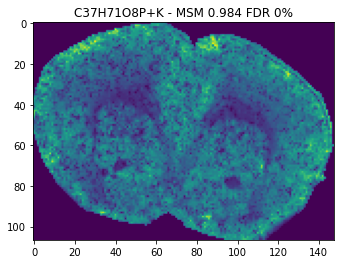

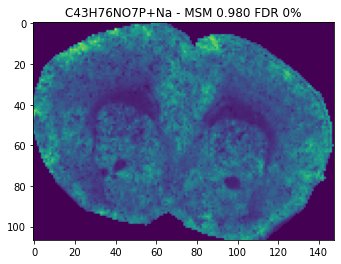

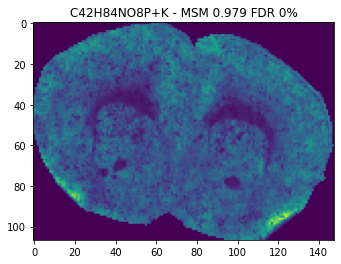

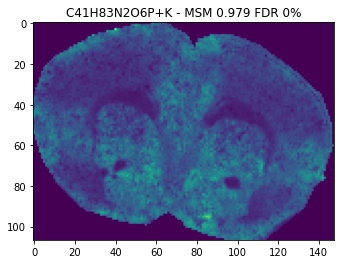

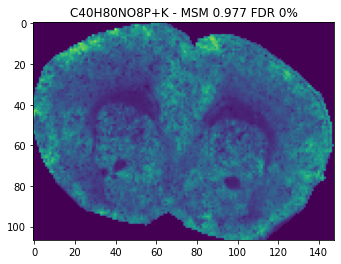

In [23]:
# Display most annotated molecules images
import matplotlib.pyplot as plt
for i, (formula_i, row) in enumerate(top_mols.head().iterrows()):
    plt.figure(i)
    plt.title(f'{row.mol}{row.modifier}{row.adduct} - MSM {row.msm:.3f} FDR {row.fdr*100:.0f}%')
    plt.imshow(formula_images[formula_i][0].toarray())

# <a name="clean"></a> 4. Clean Temp Data

In [24]:
pipeline.clean()